<a href="https://colab.research.google.com/github/EudoraHan/KobeShot-LightGBM/blob/master/KOBE_SHOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kobe Shot Evaluation and Prediction


### Yun Han  7/18/2019

### In this project, we use random forest, LGBM and GBDT model to evaluate and predict Kobe shot dataset.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving kobe_shot.csv to kobe_shot.csv


In [0]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io

## Part 1: Data Exploration

In [48]:
# 1.1 Read data:
data = pd.read_csv('kobe_shot.csv')
print(data.shape) # (30697, 25)
data.head()

(30697, 25)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,31/10/00,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,31/10/00,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,31/10/00,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,31/10/00,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,31/10/00,LAL @ POR,POR,5


In [49]:
# 1.2: Variable Selection
# 1. Remove the row without target variable: shot_made_flag
data = data[pd.notnull(data['shot_made_flag'])]
data.shape # (25697, 25)

(25697, 25)

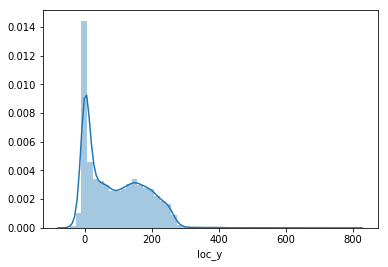

In [50]:
# 2. Compare the variable lat,lon & loc_x,loc_y. 
### Histogram
sns.distplot(data['loc_y'])

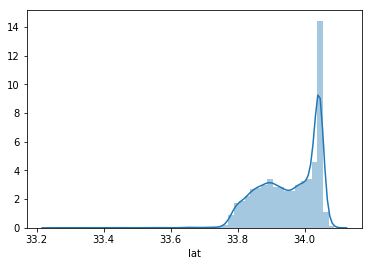

In [51]:
sns.distplot(data['lat'])

Text(0.5, 1.0, 'lat and lon')

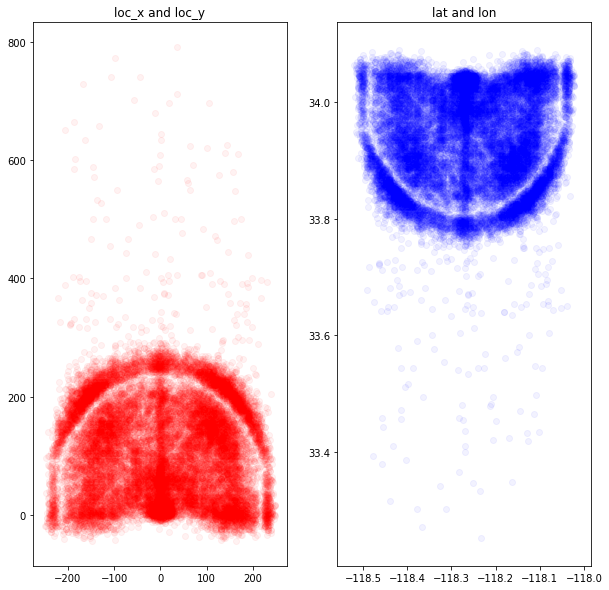

In [52]:
### Distribution Plot
plt.figure(figsize = (10,10))
 
plt.subplot(1,2,1)
plt.scatter(data.loc_x,data.loc_y,color ='r',alpha = 0.05)
plt.title('loc_x and loc_y')
 
plt.subplot(1,2,2)
plt.scatter(data.lon,data.lat,color ='b',alpha = 0.05)
plt.title('lat and lon')

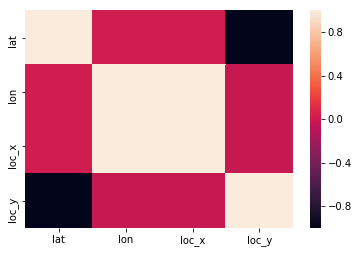

In [53]:
### Correlations Matrix and heatmap
corr = data[["lat", "lon", "loc_x", "loc_y"]].corr()
sns.heatmap(corr)

#### Both the distribution plot and the correlation matrix showed that the lat,lon & loc_x,loc_y represent the same position. We can delete one of them.



In [0]:
# 3. Time remain: 
"""
The variable 'minutes_remaining' and 'seconds_remaining' contain the same information，
we can combine the two variable together.

"""
data['remain_time'] = data['minutes_remaining'] * 60 + data['seconds_remaining']


In [55]:
# 4. shot_distance and shot_zone_range
corr = data[["shot_distance", "shot_zone_range"]].corr()
corr

,shot_distance
shot_distance,1.0


#### The correlation between shot distance and shot zone range are 1, we can delete one of them.

## Part 2:  Feature Preprocessing

In [0]:
# Delete the duplicated variable:
data = data.drop(['lat','lon','minutes_remaining', 'seconds_remaining','matchup',
                  'shot_id', 'team_id','team_name', 'shot_zone_range','game_date'], axis = 1)


### Input our auto data preprocessing function.

In [0]:
"""
Created on Wed Jul 17 13:42:10 2019
@author: Yun Han


Automatic Datapreprocessing Function
1. Data format 
2. Missing Value
3. Outlier Dectect


"""

### Data Preprocessing

### Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

"""
Part 1. Data formatting

"""

## Label Encoding for String
from sklearn.preprocessing import LabelEncoder

def labelencode(data):
    labelencoder_X = LabelEncoder()
    data = labelencoder_X.fit_transform(data)
    integer_mapping = {l: i for i, l in enumerate(labelencoder_X.classes_)}
    
    return data, integer_mapping

"""
Part 2. Use different method to deal with missing value

"""
# =============================================================================
# ### Detect missing value
# df.info() # the overview information for the dataframe
# df.describe() # basic stats
# df.isnull().sum() # the number of rows with NaN for each column
# df.notnull().sum() # the number of rows without NaN for each column
# 
# =============================================================================


def missing_value(data, method):
    if method == 'delete':
        return data.dropna(inplace=True)
    
    elif method == '0 impute':
        return data.fillna(0, inplace=True) 
    
    elif method == 'mean':
        return data.fillna(data.mean(), inplace=True)
    
    elif method == 'median':
        return data.fillna(data.median(), inplace=True)
    
    elif method == 'ffill':
        return data.fillna(method='ffill', inplace = True)
    
    elif method == 'bfill':
        return data.fillna(method='bfill', inplace = True)
    
    elif method == 'interpolation':
        return data.interpolate()

# =============================================================================
# ### KNN for imputation
#         
# from sklearn.neighbors import KNeighborsClassifier
# # construct X matrix
# X = df.iloc[:, :-1].values
# column_new = ['RevolvingUtilizationOfUnsecuredLines', 'age', 
#               'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 
#               'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 
#               'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 
#               'NumberOfDependents']
# X = pd.DataFrame(data=X, columns = column_new)
# 
# # select the rows with missing values as testing data
# idx_with_nan = X.age.isnull()
# X_with_nan = X[idx_with_nan]
# 
# # select the rows without missing values as training data
# X_no_nan = X[-idx_with_nan]
# 
# # drop name column, set age as target variable and train the model, 
# clf = KNeighborsClassifier(3, weights='distance')
# clf.fit(X_no_nan[['RevolvingUtilizationOfUnsecuredLines',
#                   'NumberOfTime30-59DaysPastDueNotWorse', 
#                   'NumberOfOpenCreditLinesAndLoans', 
#                   'NumberOfTimes90DaysLate', 
#                   'NumberRealEstateLoansOrLines', 
#                   'NumberOfTime60-89DaysPastDueNotWorse']], X_no_nan['age'])
# 
# # impute the NA value
# x_imputed = clf.predict(X_with_nan[['RevolvingUtilizationOfUnsecuredLines',
#                   'NumberOfTime30-59DaysPastDueNotWorse', 
#                   'NumberOfOpenCreditLinesAndLoans', 
#                   'NumberOfTimes90DaysLate', 
#                   'NumberRealEstateLoansOrLines', 
#                   'NumberOfTime60-89DaysPastDueNotWorse']])
# X_with_imputed = X.copy()
# X_with_imputed.loc[idx_with_nan,'age'] = x_imputed.reshape(-1)
# 
# =============================================================================

"""
Part 3. Anomaly detection/ Outliers detection
https://www.zhihu.com/question/38066650

"""

# =============================================================================
# ### Handle Outliers
# import seaborn as sns
# 
# # Simulate data
# sns.set_style('whitegrid')
# sns.distplot(df.DebtRatio)
# sns.distplot(df.MonthlyIncome)
# sns.boxplot(df.age,orient='v')
# 
# 
# =============================================================================

##### auto function for outlier

from scipy.stats import skew
    
# 1. Numeric Outlier: define a function remove outlier using IQR: one dimension
def iqr_outlier(data):
    lq,uq=np.percentile(data,[25,75])
    lower_l=lq - 1.5*(uq-lq)
    upper_l=uq + 1.5*(uq-lq)
    
    # calculate the ratio of outliers
    ratio = (len(data[(data > upper_l)])+len(data[(data < lower_l)]))/len(data)
    # if ratio is large, we might replace the outlier with boundary value.
    if ratio > 0.1:
        
        return data
    
    elif ratio > 0.05:
        data[data < lower_l] = lower_l
        data[data > upper_l] = upper_l
        print ("%d upper is:", upper_l)
        print (data,"lower is:", lower_l)
        return data
        
    else:
        return data[(data >=lower_l)&(data<=upper_l)]
    
    
# 2. Z-score：one dimension or low dimension
def z_score_outlier(data):
    
    threshold=3
    mean_y = np.mean(data)
    stdev_y = np.std(data)
    z_scores = [(y - mean_y) / stdev_y for y in data]
    
    return data[np.abs(z_scores) < threshold]

"""
Auto function for outlier： 
combine the first two function

"""

def outlier(data):
    skewness = skew(data)    
    if skewness > 1:
        remove_outlier = iqr_outlier(data)
        
    else:
        remove_outlier = z_score_outlier(data)
    
    return remove_outlier

# =============================================================================
# ### Isolation Forest: one dimension or high dimension） 
#     
# # https://zhuanlan.zhihu.com/p/27777266
#     
# from sklearn.ensemble import IsolationForest
# import pandas as pd
# 
# 
# clf = IsolationForest(max_samples=100, random_state=42)
# clf.fit(train)
# y_pred = clf.predict(train)
# y_pred = [1 if x == -1 else 0 for x in y_pred]
# y_pred.count(0) # 94714
# y_pred.count(1) # 10524  
# 
# 
# =============================================================================


"""
Part 4. Auto Datapreprocessing Function 
1. a single variable
2. Whole dataset

"""
# For a single variable

def preprocessing(i, data, type, method):    
    
    
    if type == 'numeric':    
        if data[i].dtype == 'O':
            data[i] = pd.to_numeric(data[i], errors='coerce')
            
        missing_value(data[i], method)
        clean_data = outlier(data[i])        
        return clean_data
    
    elif type == 'categorical':
        missing_value(data[i], method)
        pre_index = data[i].index
        
        if data[i].dtype == 'O':
            data, dictionary = labelencode(data[i])        
            data = pd.Series(data, name = i)
            data.index = pre_index
            clean_data = outlier(data)    
        else:
            clean_data = outlier(data[i])  
        return clean_data


# For a whole dataset

def clean_all(df, categorical, method_cate, method_numeric):    
    for i in df.columns:
        if i not in categorical: 
            clean = preprocessing(i, df, 'numeric', method_numeric)
            if len(clean) < len(df):
                df = pd.merge(clean, df, left_index=True,right_index=True, how='left',suffixes=('_x', '_delete')) # left_on, right_on
            else:
                df = pd.merge(clean, df, left_index=True,right_index=True, how='right',suffixes=('_x', '_delete')) # left_on, right_on
      
        else:
            clean = preprocessing(i, df, 'categorical', method_cate)
            if len(clean) < len(df):
                df = pd.merge(clean, df, left_index=True,right_index=True, how='left',suffixes=('_x', '_delete')) # left_on, right_on
            else:
                df = pd.merge(clean, df, left_index=True,right_index=True, how='right',suffixes=('_x', '_delete')) # left_on, right_on
    
    for name in df.columns:
        if "_delete"  in name:
            df = df.drop([name], axis=1)
    
    return df



### Use auto-data preprocessing function 

In [0]:
# Use auto-data preprocessing fucntion
cat = ['action_type', 'combined_shot_type', 'period', 'playoffs','season', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'opponent']        
after_Clean = clean_all(data, cat, 'delete', 'median')        


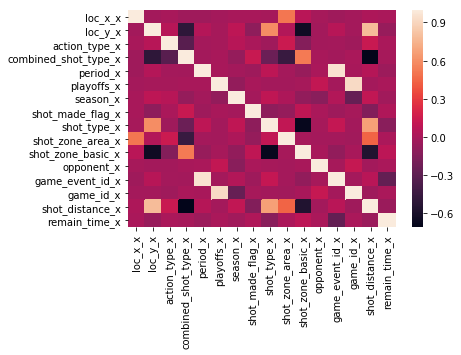

In [20]:
corr = after_Clean[['loc_x_x', 'loc_y_x','action_type_x', 'combined_shot_type_x', 'period_x', 'playoffs_x',
             'season_x', 'shot_made_flag_x','shot_type_x', 'shot_zone_area_x', 'shot_zone_basic_x',
             'opponent_x','game_event_id_x','game_id_x','shot_distance_x', 'remain_time_x']].corr()
sns.heatmap(corr)


#### From the correlation matrix, we find that the correlation between shot_distance and loc_y is 0.79, game_event_id and period is 0.96, game_id and playoffs is 0.92, hence, we can delete one of each pair.


In [0]:
# Delete the high correlation variable: shot_distance, game_event_id,game_id
shot = after_Clean.drop(['shot_distance_x','game_event_id_x','game_id_x'], axis = 1)


## Part 3: Model Training --- Random Forest

In [0]:
X = shot.drop(['shot_made_flag_x'], axis = 1)
y = shot.iloc[:, 5].values

In [23]:
# One HotEncoder: Encoding categorical data
# Encoding the Independent Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
onehotencoder = OneHotEncoder(categorical_features = [1,2,3,5,7,10,11])
X = onehotencoder.fit_transform(X).toarray()


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


### Part 3.1: Split dataset

In [0]:
# 3.1: Split dataset
# Splite data into training and testing
from sklearn import model_selection
# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state = 0)


### Part 3.2: Model Training and Selection

In [0]:
# 3.2: Model Training and Selection
from sklearn.ensemble import RandomForestClassifier
# Random Forest
classifier_RF = RandomForestClassifier()


In [26]:
# Train the model
classifier_RF.fit(X_train, y_train)
# Prediction of test data
classifier_RF.predict(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0., 0., 0., ..., 0., 1., 1.])

In [0]:
# Accuracy of test data
classifier_RF.score(X_test, y_test) 


0.6301567656765676

In [0]:
# Use 5-fold Cross Validation to get the accuracy # 0.6192
cv_score = model_selection.cross_val_score(classifier_RF, X_train, y_train, cv=5)
print('Model accuracy of Random Forest is:',cv_score.mean())


Model accuracy of Random Forest is: 0.6267477710944356


###  Part 3.3: Use Grid Search to Find Optimal Hyperparameters

In [0]:
# 3.3: Use Grid Search to Find Optimal Hyperparameters
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))



In [0]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [80,90],
    'max_features' : ['auto','sqrt','log2'],
    'min_samples_leaf' : [1,10,50,100]
    
}

# Use time function to measure time elapsed
import time
start = time.time()

Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

end = time.time()
print(end - start)

187.79808497428894


In [0]:
# best number of tress
print_grid_search_metrics(Grid_RF)


Best score: 0.668
Best parameters set:
	max_features: 'auto'
	min_samples_leaf: 10
	n_estimators: 80


In [0]:
# best random forest
best_RF_model = Grid_RF.best_estimator_


### Part 3.4: Use Random Search to Find Optimal Hyperparameters


In [0]:
# 3.4: Use Random Search to Find Optimal Hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# helper function for printing out grid search results 
def print_random_search_metrics(rs):
    print ("Best score: %0.3f" % rs.best_score_)
    print ("Best parameters set:")
    best_parameters = rs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))




In [29]:

# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [80,90],
    'max_features' : ['auto','sqrt','log2'],
    'min_samples_leaf' : [1,10,50,100]
}

# Use time function to measure time elapsed
import time
start = time.time()

Random_RF = RandomizedSearchCV(RandomForestClassifier(),parameters, cv=5)
Random_RF.fit(X_train, y_train)

end = time.time()
print(end - start)

88.73095989227295


In [0]:
# best number of tress
print_grid_search_metrics(Random_RF)

Best score: 0.668
Best parameters set:
	max_features: 'sqrt'
	min_samples_leaf: 10
	n_estimators: 90


### Part 3.5: Use Bayesian Optimization to Find Optimal Hyperparameters

In [30]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
rf = RandomForestClassifier()
def rf_cv(n_estimators, min_samples_leaf, max_features):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators),
            min_samples_leaf=int(min_samples_leaf),
            max_features=min(max_features, 0.999), # float
            random_state=2
        ),
        X, y, scoring= 'accuracy', cv=5
    ).mean()
    return val

In [0]:
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (10, 250),
         'min_samples_leaf': (2, 25),
         'max_features': (0.1, 0.999)
        }
)

In [115]:
# Use time function to measure time elapsed
import time
start = time.time()

num_iter = 10
init_points = 5
rf_bo.maximize(init_points=init_points,n_iter=num_iter)

end = time.time()
print(end - start)

|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.6362   |  0.3618   |  3.493    |  12.25    |
|  2        |  0.6646   |  0.1639   |  14.34    |  204.0    |
|  3        |  0.6588   |  0.8935   |  23.97    |  148.7    |
|  4        |  0.6475   |  0.8533   |  2.733    |  203.6    |
|  5        |  0.6587   |  0.8141   |  22.84    |  240.9    |
|  6        |  0.6551   |  0.999    |  25.0     |  10.0     |
|  7        |  0.6591   |  0.9986   |  24.95    |  201.6    |
|  8        |  0.667    |  0.1127   |  24.84    |  68.14    |
|  9        |  0.6582   |  0.1071   |  2.027    |  108.4    |
|  10       |  0.6656   |  0.1      |  24.63    |  101.6    |
|  11       |  0.6632   |  0.107    |  5.121    |  250.0    |
|  12       |  0.6659   |  0.1      |  25.0     |  35.28    |
|  13       |  0.6664   |  0.1137   |  24.62    |  179.8    |
|  14       |  0.6664   |  0.1197   |  24.87    |  216.6    |
|  15   

In [0]:
rf_bo.max

{'params': {'max_depth': 5.08900552171501,
  'max_features': 0.18226085009058457,
  'min_samples_split': 24.775708453366086,
  'n_estimators': 174.04350508403547},
 'target': 0.6683580716980221}

## Part 4: Model Training --- LGBM

In [0]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, train_test_split
from lightgbm import LGBMClassifier


### Part 4.1: Model Training and Selection

In [0]:
lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=50,
    colsample_bytree=.8,
    subsample=.9,
    max_depth=7,
    reg_alpha=.1,
    reg_lambda=.1,
    min_split_gain=.01,
    min_child_weight=2,
    silent=-1,
    verbose=-1,
)

#### Fit the model

In [28]:
lgbm.fit(X_train, y_train, 
    eval_set= [(X_train, y_train), (X_test, y_test)], 
    eval_metric='auc', verbose=100, early_stopping_rounds=30  #30
)


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.601406	training's auc: 0.737307	valid_1's binary_logloss: 0.619088	valid_1's auc: 0.688686


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.05, max_depth=7,
               min_child_samples=20, min_child_weight=2, min_split_gain=0.01,
               n_estimators=400, n_jobs=-1, num_leaves=50, objective=None,
               random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent=-1,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

In [29]:
# Use 5-fold Cross Validation to get the accuracy # 0.6192
cv_score = model_selection.cross_val_score(lgbm, X_train, y_train, cv=5)
print('Model accuracy of LGBM is:',cv_score.mean())


Model accuracy of LGBM is: 0.656866550527722


### Part 4.2: Use Grid Search to Find Optimal Hyperparameters

In [0]:
# Possible hyperparamter options for LigntGBM
# Choose the number of trees
parameters = {
    'n_estimators' : [100, 200, 300, 400],
    'learning_rate' : [0.03, 0.05, 0.08, 0.1, 0.2],
    'num_leaves' : [30, 50, 80],
    'max_depth': [5, 10, 20, 30]
}

# Use time function to measure time elapsed
import time
start = time.time()

Grid_LGBM = GridSearchCV(LGBMClassifier(),parameters, cv=5)
Grid_LGBM.fit(X_train, y_train)


end = time.time()
print(end - start)

940.9568140506744


In [0]:
# best number of tress
print_grid_search_metrics(Grid_LGBM)

Best score: 0.668
Best parameters set:
	learning_rate: 0.03
	max_depth: 5
	n_estimators: 300
	num_leaves: 30


### Part 4.3: Use Random Search to Find Optimal Hyperparameters

In [0]:
# 4.3: Use Random Search to Find Optimal Hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# helper function for printing out grid search results 
def print_random_search_metrics(rs):
    print ("Best score: %0.3f" % rs.best_score_)
    print ("Best parameters set:")
    best_parameters = rs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))




In [0]:
# Possible hyperparamter options for LightGBM
# Choose the number of trees
parameters = {
    'n_estimators' : [60, 80, 100, 200, 300],
    'learning_rate' : [0.03, 0.05, 0.08, 0.1, 0.2],
    'num_leaves' : [20, 30, 50],
    'max_depth': [10, 20, 30]
}

# Use time function to measure time elapsed
import time
start = time.time()

Random_LGBM = RandomizedSearchCV(LGBMClassifier(),parameters, cv=5)
Random_LGBM.fit(X_train, y_train)

end = time.time()
print(end - start)

18.503878831863403


In [0]:
# best number of tress
print_grid_search_metrics(Random_LGBM)

Best score: 0.667
Best parameters set:
	learning_rate: 0.05
	max_depth: 30
	n_estimators: 60
	num_leaves: 50


### Part 4.4: Use Bayesian Optimazition to Find Optimal Hyperparameters

In [0]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [0]:
LGBM = LGBMClassifier()
def LGBM_cv(n_estimators, learning_rate, num_leaves, max_depth,lambda_l1):
    val = cross_val_score(
        LGBMClassifier(n_estimators = int(n_estimators),
            learning_rate = learning_rate,
            num_leaves = int(num_leaves),
            max_depth = int(max_depth),
            lambda_l1 = lambda_l1,
            random_state = 2
        ),
        X, y, scoring= 'accuracy', cv=5
    ).mean()
    return val

In [0]:
LGBM_bo = BayesianOptimization(
        LGBM_cv,
        {'n_estimators': (10, 250),
         'learning_rate' : (0.01, 2.0),
         'num_leaves': (5, 130),
         'max_depth': (4, 20),
         'lambda_l1': (0, 6)}
)

In [0]:
# Use time function to measure time elapsed
import time
start = time.time()

num_iter = 10
init_points = 5
LGBM_bo.maximize(init_points=init_points,n_iter=num_iter)

end = time.time()
print(end - start)

|   iter    |  target   | lambda_l1 | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------------------
|  1        |  0.6495   |  1.961    |  0.1331   |  7.443    |  188.6    |  31.95    |
|  2        |  0.5554   |  1.387    |  1.985    |  15.65    |  27.77    |  55.66    |
|  3        |  0.5164   |  1.74     |  1.991    |  6.956    |  70.04    |  82.4     |
|  4        |  0.5969   |  0.2214   |  1.075    |  5.229    |  109.6    |  123.1    |
|  5        |  0.6251   |  3.696    |  0.8189   |  13.79    |  57.76    |  54.53    |
|  6        |  0.662    |  6.0      |  0.01     |  20.0     |  250.0    |  130.0    |
|  7        |  0.5742   |  6.0      |  0.01     |  4.0      |  10.0     |  5.0      |
|  8        |  0.6666   |  6.0      |  0.01     |  20.0     |  250.0    |  5.0      |
|  9        |  0.4921   |  0.0      |  2.0      |  20.0     |  114.6    |  5.0      |
|  10       |  0.6625   |  6.0      |  0.01     |  20.

In [0]:
LGBM_bo.max

{'params': {'lambda_l1': 6.0,
  'learning_rate': 0.01,
  'max_depth': 4.0,
  'n_estimators': 216.90519644528626,
  'num_leaves': 130.0},
 'target': 0.6669551420508177}

## Part 5: Model Training --- GBDT

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

### Part 5.1: Model Training and Selection



In [32]:
gbr = GradientBoostingClassifier(n_estimators=300, max_depth=2, min_samples_split=2, learning_rate=0.1)
gbr.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [33]:
# Prediction of test data
gbr.predict(X_test)

array([0., 0., 0., ..., 0., 0., 1.])

In [34]:
# Accuracy of test data
gbr.score(X_test, y_test) 

0.6745049504950495

### Part 5.2: Use Grid Search to Find Optimal Hyperparameters


In [45]:
# Possible hyperparamter options for GBDT
# Choose the number of trees
parameters = {
    'n_estimators' : [100],
    'learning_rate' : [0.1],
    'min_samples_split' :[2],
    'max_depth': [2]

}

# Use time function to measure time elapsed
import time
start = time.time()

Grid_GBDT = GridSearchCV(GradientBoostingClassifier(),parameters, cv=3)
Grid_GBDT.fit(X_train, y_train)


end = time.time()
print(end - start)

11.35716199874878


In [46]:
# best number of tress
print_grid_search_metrics(Grid_GBDT)

Best score: 0.668
Best parameters set:
	learning_rate: 0.1
	max_depth: 2
	min_samples_split: 2
	n_estimators: 100


### Part 5.3: Use Random Search to Find Optimal Hyperparameters

In [0]:
# 5.3: Use Random Search to Find Optimal Hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# helper function for printing out grid search results 
def print_random_search_metrics(rs):
    print ("Best score: %0.3f" % rs.best_score_)
    print ("Best parameters set:")
    best_parameters = rs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))




In [36]:
# Possible hyperparamter options for LightGBM
# Choose the number of trees
parameters = {
    'n_estimators' : [60, 80, 100, 200, 300],
    'learning_rate' : [0.03, 0.05, 0.08, 0.1, 0.2],
    'min_samples_split' :[2, 25],
    'max_depth': [2, 5, 8]
        
}

# Use time function to measure time elapsed
import time
start = time.time()

Random_GBDT = RandomizedSearchCV(GradientBoostingClassifier(),parameters, cv=5)
Random_GBDT.fit(X_train, y_train)

end = time.time()
print(end - start)

472.7206542491913


In [0]:
# best number of tress
print_grid_search_metrics(Random_GBDT)

Best score: 0.667
Best parameters set:
	learning_rate: 0.08
	max_depth: 2
	min_samples_split: 25
	n_estimators: 60


### Part 5.4: Use Bayesian Optimazition to Find Optimal Hyperparameters

In [0]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [0]:
GBDT = GradientBoostingClassifier()
def GBDT_cv(n_estimators, learning_rate, min_samples_split, max_depth):
    val = cross_val_score(
        GradientBoostingClassifier(n_estimators = int(n_estimators),
            learning_rate = learning_rate,
            min_samples_split=int(min_samples_split),
            max_depth = int(max_depth),
            random_state = 2
        ),
        X, y, scoring= 'accuracy', cv=5
    ).mean()
    return val

In [0]:
GBDT_bo = BayesianOptimization(
        GBDT_cv,
        {'n_estimators': (100, 300),
         'learning_rate' : (0.01, 0.2),
         'min_samples_split' :(2, 25),
         'max_depth': (2, 10)
        }
)

In [0]:
# Use time function to measure time elapsed
import time
start = time.time()

num_iter = 10
init_points = 5
GBDT_bo.maximize(init_points=init_points,n_iter=num_iter)

end = time.time()
print(end - start)

|   iter    |  target   | learni... | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  20       |  0.6601   |  0.1183   |  3.98     |  24.39    |  190.4    |
|  21       |  0.6601   |  0.0304   |  5.925    |  20.28    |  222.8    |
|  22       |  0.6614   |  0.06898  |  4.586    |  18.85    |  146.2    |
|  23       |  0.6526   |  0.08733  |  5.392    |  21.93    |  211.0    |
|  24       |  0.6645   |  0.04976  |  2.35     |  24.66    |  166.9    |
|  25       |  0.6535   |  0.02413  |  9.515    |  2.007    |  139.0    |
|  26       |  0.664    |  0.09761  |  2.075    |  24.96    |  266.0    |
|  27       |  0.6654   |  0.02553  |  2.094    |  12.34    |  132.1    |
|  28       |  0.6557   |  0.01     |  9.445    |  25.0     |  283.3    |
|  29       |  0.6644   |  0.0751   |  2.013    |  2.319    |  153.6    |
|  30       |  0.6455   |  0.05067  |  9.923    |  24.97    |  238.6    |
|  31       |  0.6168   |  0.1351   | 

In [0]:
GBDT_bo.max

{'params': {'learning_rate': 0.01,
  'max_depth': 2.000000029868887,
  'min_samples_split': 14.215169189609608,
  'n_estimators': 106.04429937904912},
 'target': 0.6684405969713871}